In [1]:
import numpy as np
import pandas as pd
import covidecg.data.utils
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import covidecg.models.mlp_models
import skorch
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from skorch.callbacks import EpochScoring, EarlyStopping
import sklearn.svm
import sklearn.metrics
from sklearn.preprocessing import FunctionTransformer


X, y = covidecg.data.utils.load_runs('../data/interim/ecg_runs.csv', '../data/interim/ecg_runs')

# pre-process targets
label_encoder = sklearn.preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y).astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# compute class weights for CrossEntropyLoss to mitigate imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [35]:
fitted_models = {}

# models to compare
pipe_svm_linear = sklearn.pipeline.Pipeline([
    ('flatten_leads', FunctionTransformer(covidecg.data.utils.flatten_leads)),
    ('SVM (linear kernel)', sklearn.svm.SVC(kernel='linear')),
])
pipe_svm_poly = sklearn.pipeline.Pipeline([
    ('flatten_leads', FunctionTransformer(covidecg.data.utils.flatten_leads)),
    ('SVM (polyn. kernel)', sklearn.svm.SVC(kernel='poly')),
])
pipe_svm_linear_lead_ii = sklearn.pipeline.Pipeline([
    ('select_lead_ii', covidecg.data.utils.EcgLeadSelector('MDC_ECG_LEAD_II'))
    ('SVM (linear kernel)', sklearn.svm.SVC(kernel='linear')),
])

experiments_sklearn = [
    ('raw_signal__all_leads__svm_linear', pipe_svm_linear),
    ('raw_signal__all_leads__svm_polyn', pipe_svm_poly),
    ('raw_signal__lead_ii__svm_linear', pipe_svm_linear_lead_ii),
]
experiments_sklearn.append(('raw_signal__lead_ii__svm_polyn', 
    sklearn.pipeline.make_pipeline(
        covidecg.data.utils.EcgLeadSelector('MDC_ECG_LEAD_II'), 
        sklearn.svm.SVC(kernel='poly'))))

for _exp_name, _pipe in experiments_sklearn:
    # fit model
    print(f"Fitting {_exp_name}")
    _pipe.fit(X_train, y_train)
    fitted_models[_exp_name] = _pipe
    # evaluate model
    y_pred = _pipe.predict(X_test)
    print("Balanced accuracy:", sklearn.metrics.balanced_accuracy_score(y_test, y_pred))
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print("-----------------------------------------")

Fitting SVM (linear kernel)
Balanced accuracy: 0.5044694908666926 

Confusion matrix:
[[130  36]
 [ 48  14]]
-----------------------------------------
Fitting SVM (polyn. kernel)
Balanced accuracy: 0.5 

Confusion matrix:
[[166   0]
 [ 62   0]]
-----------------------------------------


In [6]:
# build PyTorch model in skorch wrapper
clf = skorch.NeuralNetClassifier(
    module=covidecg.models.mlp_models.MLP,
    # topology config
    module__input_size=X_train[0].size,  # number of features in flattened sample
    module__hidden_size=1000,
    # loss config
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights,
    # hyperparams
    batch_size=32,
    lr=1e-4,
    optimizer__momentum=0.9,
    max_epochs=20,
    iterator_train__shuffle=True,  # Shuffle training data on each epoch
    callbacks=[
        # additional scores to observe
        EpochScoring(scoring='roc_auc', lower_is_better=False),
        # Early Stopping based on validation loss
        EarlyStopping(patience=3)
        ]
)

experiments_torch = []
fitted_models_torch = {}

experiments_torch.append(('raw_signal__all_leads__mlp',
    sklearn.pipeline.make_pipeline(
        FunctionTransformer(covidecg.data.utils.flatten_leads),
        clf)))

experiments_torch.append(('raw_signal__lead_ii__mlp',
    sklearn.pipeline.make_pipeline(
        FunctionTransformer(covidecg.data.utils.flatten_leads),
        clf)))

# train the model
for _exp_name, _pipe in experiments_torch:
    print(f"Fitting {_exp_name}")
    _pipe.fit(X=X_train, y=y_train)
    fitted_models_torch[_exp_name] = _pipe

Fitting raw_signal__all_leads__mlp
  epoch    roc_auc    train_loss    valid_acc    valid_loss      dur
-------  ---------  ------------  -----------  ------------  -------
      1     0.4793        0.7270       0.4560        0.7316  15.0200
Fitting raw_signal__lead_ii__mlp
Re-initializing module because the following parameters were re-set: hidden_size, input_size.
Re-initializing criterion because the following parameters were re-set: weight.
Re-initializing optimizer.


In [ ]:
# clf = skorch.NeuralNetClassifier(
#     module=covidecg.models.mlp_models.MLP,
#     # topology config
#     module__input_size=X_train[0].size,  # number of features in flattened sample
#     module__hidden_size=1000,
#     # training config
#     criterion=nn.CrossEntropyLoss,
#     criterion__weight=class_weights,
#     optimizer=torch.optim.Adam,
#     batch_size=64,
#     max_epochs=20,
#     train_split=0.2,  # 20% for validation
#     iterator_train__shuffle=True,  # Shuffle training data on each epoch
#     callbacks=[
#         # additional scores to observe
#         EpochScoring(scoring='roc_auc', lower_is_better=False),
#         # Early Stopping based on validation loss
#         EarlyStopping(patience=3)
#         ]
# )

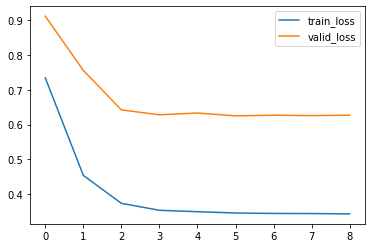

In [32]:
import matplotlib.pyplot as plt
plt.plot(clf.history[:, 'train_loss'], label='train_loss')
plt.plot(clf.history[:, 'valid_loss'], label='valid_loss')
plt.legend()
plt.show()

/home/scheralph/source/covid-ecg/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


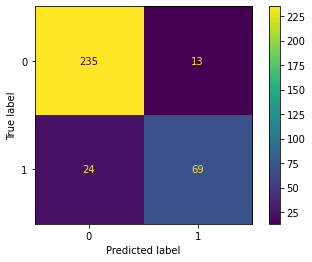

In [33]:
sklearn.metrics.plot_confusion_matrix(pipe, X_test, y_test)

In [ ]:
# save model to disk
clf.save_params(f_params='model.pkl', f_optimizer='optim.pkl', f_history='history.json')